In [1]:
import pandas as pd

carseats = pd.read_csv("../../data/Carseats.csv")
carseats

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


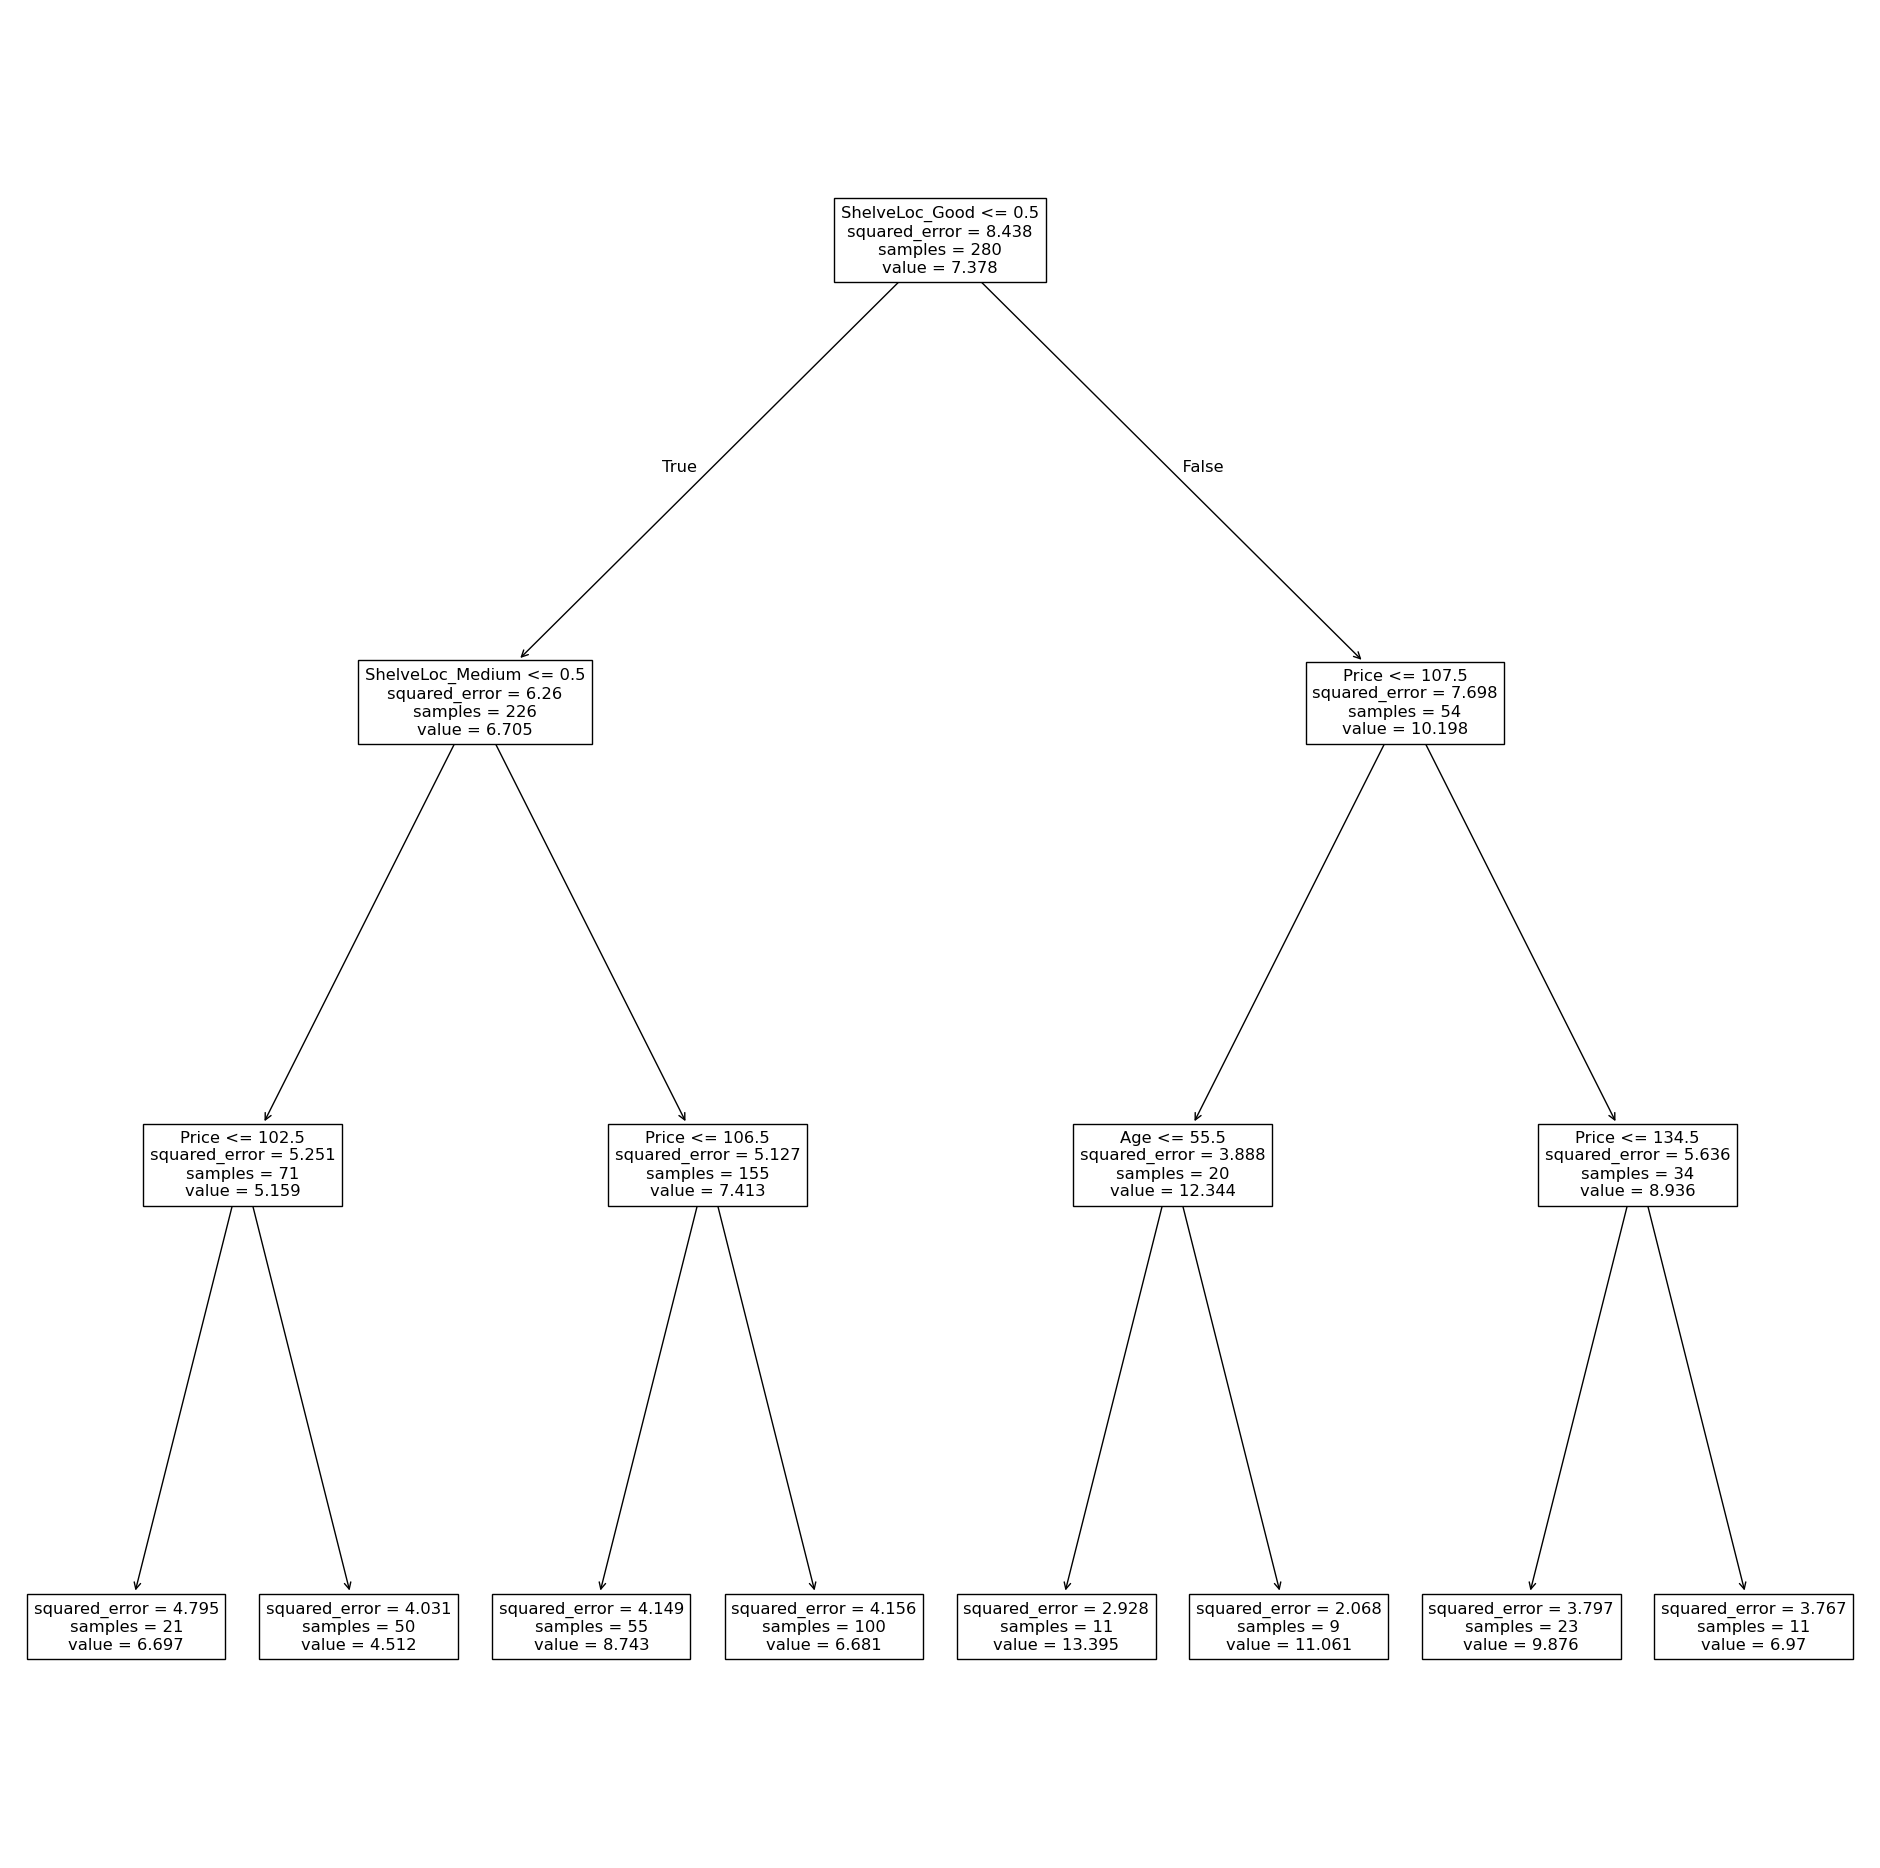

In [ ]:
from sklearn.tree import DecisionTreeRegressor as DTR, plot_tree
import sklearn.model_selection as skm
import matplotlib.pyplot as plt

X = carseats[carseats.columns.drop("Sales")]
Y = carseats["Sales"]

X_encoded = pd.get_dummies(X, drop_first=True)

(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X_encoded,
                                Y,
                                test_size=0.3,
                                random_state=0)


reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = plt.subplots(figsize=(24,24))[1]

feature_names = X_encoded.columns

plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [10]:
import numpy as np

y_hat = reg.predict(X_test)
np.mean((y_test - y_hat)**2)

np.float64(3.7038582752360942)

The regression tree for predicting **Sales** in the Carseats dataset reveals that **shelf location** is the most important predictor. The root split occurs on **ShelveLoc_Good**, indicating that stores with a good shelf location generally have higher sales. Subsequent splits show that stores with a medium shelf location are further differentiated based on **Price**, suggesting that price also significantly affects sales. On the right branch, for stores without a good shelf location, **Price** and **Age** are used to further split the data, indicating that older stores and certain price ranges are associated with different sales levels. The terminal nodes display the predicted sales values and the number of observations, showing that the tree segments the data into relatively homogeneous groups, with lower squared errors in the leaves where the splits successfully isolate similar sales patterns. Overall, the tree highlights the dominant effect of shelf placement, followed by price and store age, in determining sales outcomes.

In [19]:
reg = DTR(max_depth=None)
reg.fit(X_train, y_train)
y_hat = reg.predict(X_test)
np.mean((y_test - y_hat)**2)

np.float64(5.310036666666666)

In [20]:
ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
kfold = skm.KFold(5,
                  shuffle=True,
                  random_state=10)
grid = skm.GridSearchCV(reg,
                        {'ccp_alpha': ccp_path.ccp_alphas},
                        refit=True,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
G = grid.fit(X_train, y_train)

best_ = G.best_estimator_
np.mean((y_test - G.predict(X_test))**2)

np.float64(4.720207731481482)

Pruning a decision tree with **max_depth=3** did not change the test error because the tree was already quite shallow and simple, so there were no internal splits that could be removed to reduce complexity further; essentially, the tree was already “pruned” by its depth constraint. When the **max_depth** restriction was removed, the tree grew deeper, leading to overfitting on the training data, which caused the test error to increase. Applying cost-complexity pruning in this deeper tree now had an effect, as it removed some of the unnecessary splits, reducing overfitting and lowering the test error. However, even after pruning, the test error did not fall below that of the original depth-3 tree, indicating that the shallow tree was already near the optimal balance between bias and variance for this dataset.

In [ ]:
from sklearn.ensemble import RandomForestRegressor as RF

bag_carseats = RF(max_features=X_train.shape[1], random_state=0)
bag_carseats.fit(X_train, y_train)

y_hat_bag = bag_carseats.predict(X_test)
np.mean((y_test - y_hat_bag)**2)

np.float64(2.0281161332500006)

In [28]:
feature_imp = pd.DataFrame(
    {'importance':bag_carseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.277294
ShelveLoc_Good,0.222583
Age,0.107775
CompPrice,0.097186
ShelveLoc_Medium,0.082756
Advertising,0.073830
Income,0.053136
Population,0.041544
Education,0.031885
US_Yes,0.006801


After applying bagging to the model, the feature importances indicate which variables most strongly influence predictions. **Price** emerges as the most important predictor, contributing roughly 28% to the model’s decisions, followed closely by **ShelveLoc_Good** at about 22%, highlighting the impact of shelf location on sales. **Age**, **CompPrice**, and **ShelveLoc_Medium** also show notable influence, while features such as **Advertising**, **Income**, and **Population** contribute moderately. Variables like **Education**, **US_Yes**, and **Urban_Yes** have minimal impact. Bagging aggregates multiple trees, which tends to stabilize importance measures, reduce variance, and highlight the features consistently driving the model’s predictions. The test error also declined to approximately 2.03, indicating a clear improvement in predictive performance. Overall, price and favorable shelf location dominate the predictive power, while demographic variables play a smaller role.

In [30]:
RF_cartseats = RF(max_features=4,
               random_state=0).fit(X_train, y_train)
y_hat_RF = RF_cartseats.predict(X_test)
np.mean((y_test - y_hat_RF)**2)

np.float64(2.0791723399166666)

In [31]:
feature_imp = pd.DataFrame(
    {'importance':RF_cartseats.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
Price,0.252003
ShelveLoc_Good,0.173289
Age,0.118841
CompPrice,0.097818
Advertising,0.088960
Income,0.077895
Population,0.066774
ShelveLoc_Medium,0.057671
Education,0.043725
US_Yes,0.013563


Using a random forest with 4 features considered at each split distributes importance more broadly across the variables, with **Price** remaining the most influential at around 25%, followed by **ShelveLoc_Good** at 17%, and **Age** and **CompPrice** also contributing noticeably. Other variables such as **Advertising**, **Income**, and **Population** have moderate influence, while **ShelveLoc_Medium**, **Education**, **US_Yes**, and **Urban_Yes** play minor roles. Compared to bagging, the importance of the top features is slightly lower, reflecting the additional randomness in feature selection at each split. This extra randomness slightly increased the test error relative to bagging, which had considered all features at every split, suggesting that while random forests help reduce correlation among trees, in this particular dataset the bagging approach with full feature consideration yielded marginally better predictive performance.

In [33]:
from ISLP.bart import BART

X_train_bart = X_train.astype(np.float32)
y_train_bart = y_train.astype(np.float32)

bart_carseats = BART(random_state=0, burnin=5, ndraw=15)
bart_carseats.fit(X_train_bart, y_train_bart)

X_test_bart = X_test.astype(np.float32)
yhat_test = bart_carseats.predict(X_test_bart)

np.mean((y_test - yhat_test)**2)

np.float64(1.7090157850036667)

In [34]:
var_inclusion = pd.Series(bart_carseats.variable_inclusion_.mean(0),
                               index=feature_names)
var_inclusion

CompPrice           31.200000
Income              23.466667
Advertising         26.333333
Population          22.466667
Price               36.066667
Age                 24.400000
Education           24.400000
ShelveLoc_Good      32.866667
ShelveLoc_Medium    27.200000
Urban_Yes           23.200000
US_Yes              28.133333
dtype: float64

Using BART, the model achieved the lowest test error among all methods considered, indicating superior predictive accuracy. BART works by averaging over many regression trees sampled from a posterior distribution, which naturally balances bias and variance. The **variable_inclusion_** values quantify the proportion of posterior draws in which each feature was used to split a tree, effectively measuring each feature’s relevance in the ensemble. For example, **Price** and **ShelveLoc_Good** have the highest inclusion probabilities (\~36% and \~33%, respectively), reflecting their consistent influence across the ensemble, while features such as **Population** and **Income** are selected less frequently (\~22–23%). This probabilistic approach allows BART to effectively identify and emphasize important predictors, leading to more stable predictions and the lowest test error compared to single trees, bagging, or random forests.